## State-level Simulations


Model spread of infection across heterogenoues state of defined population centres in discrete districts with an inferred interaaction rule based on cultural affinity.


## Preamble

Load modules and setup some useful parameters for latter on

In [1]:
using LightGraphs, Plots, GraphPlot, Compose, Random

In [2]:
include("ContactModels.jl")

buildstate (generic function with 4 methods)

In [3]:
include("EpiSim.jl")

Main.EpiSim

## Load the data

In [4]:
using CSV, DataFrames

In [5]:
wapop=CSV.read("remote-wa.csv", DataFrame)

┌ Warning: thread = 1 warning: only found 14 / 15 columns around data row: 118. Filling remaining columns with `missing`
└ @ CSV /home/michael/.julia/packages/CSV/YUbbG/src/file.jl:603


,City / Town,Column2,Region,Remoteness Areas
,String?,String?,String?,String?
1,Perth,"1,874,578",Perth,Major Cities of Australia
2,missing,missing,Perth,Remote
3,Bunbury,"71,090",South West,Inner Regional Australia
4,missing,missing,South West,Outer Regional Australia
5,Geraldton,"31,982",Mid West,Inner Regional Australia
6,missing,missing,Mid West,Outer Regional Australia
7,Kalgoorlie-Boulder,"29,875",Goldfields-Esperance,Inner Regional Australia
8,missing,missing,Goldfields-Esperance,Outer Regional Australia
9,Albany,"29,373",Great Southern,Inner Regional Australia


## Infer similarity

We need to construct a movement matrix indicating how much transport of people (virus) there is between every two locales in the state. Ideally, we could use mobile phone telemetry data or other transport information. But we dont have that. In lieu of that information, an as we are primarily interested in movement to/from remote communities we have chosen to use similarity in indigienoues language grouping between towns - effectively the dot product of the vector consisting of native langauge speakers across several different indigenoues language groups. This will group remote regions based on shared culture.

The other open question is "how much? effectively the output of similaritytown can be scaled by an arbitrary monotonic (increasing) function. This is done to control mixing. In practise this is not a big deal as it only mattters that we get the order of magnitude correct. That is, the inter-community links should not swamp the intra-community structure - a computation of modularity across the state could control for this (not done yet).


In [6]:
function similaritytown(df,i,j)
    # similaritytown(df,i,j)
    # Define a "similarity" between two locations. This code is an ad-hoc rule that is an 
    # attempt to model the amount of movement between discrete regions. Dataframe df is 
    # assumed to be in the Orlando format as illustrated above.
    bonus=100  #effectively, the larger the bonus, the more we include non-indigeneos travel.
    x1= Matrix(df[2*i-1:2*i,5:end])# convert(Matrix{Int}, df[2*i-1:2*i,5:end])
    x2= Matrix(df[2*j-1:2*j,5:end])#convert(Matrix{Int}, df[2*j-1:2*j,5:end])
#   languagesimilarity=sum(x1[:],dims=1)'*sum(x2[:],dims=1) #amalgamates the two different classifications of the boundary of a locale
    languagesimilarity=x1[:]'*x2[:]        #or not
    regionbonus= (df[2*i,3]==df[2*j,3])*bonus
    score=Int(floor(sqrt(languagesimilarity+regionbonus))) # sqrt? why not?
    return score
end

similaritytown (generic function with 2 methods)

In [7]:
dist=Array{Int,2}(undef,58,58)
for i in 1:58
    for j in 1:58
        dist[i,j]=similaritytown(wapop,i,j)
    end
end

## Visualise

As an aside, let do some quick visualisation of the structure of this distance matrix and the inferred graph between locales across the state. Do the groupings match intuition/expectation?

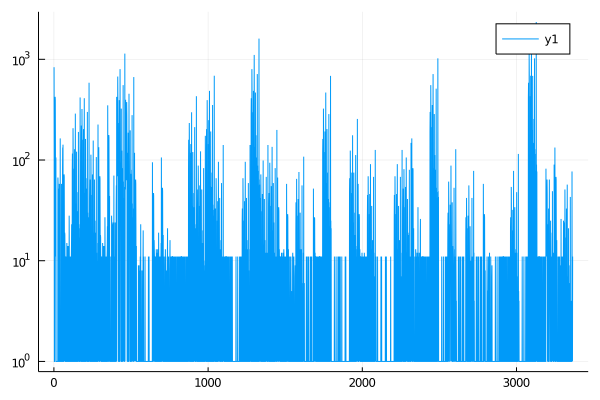

In [8]:
plot(dist[:].+1,yaxis=:log)

In [9]:
using LightGraphs, GraphPlot, SimpleWeightedGraphs, Plots

In [10]:
# extract information from dataframe
#
#population
townpop=wapopint=parse.(Int, replace.(wapop[1:2:end,2], r","=> ""))
townpop=townpop[1:end-1]
#region and assign colouring
nodecolor = [colorant"lightseagreen", colorant"orange", colorant"red", colorant"green", colorant"yellow", colorant"brown", colorant"pink", colorant"purple", colorant"blue", colorant"violet"]
townlabel=wapop[1:2:end,3]
townlabel=townlabel[1:end-1]
regions=unique(townlabel)
regioni=Array{Int,1}(undef,58)
for i in 1:58
    regioni[i]=findall(x->x==1,townlabel[i].==regions)[1]
end
nodefillc = nodecolor[regioni]
#town names
townlabel=wapop[1:2:end,1]
townlabel=townlabel[1:end-1]

58-element Array{Union{Missing, String},1}:
 "Perth"
 "Bunbury"
 "Geraldton"
 "Kalgoorlie-Boulder"
 "Albany"
 "Busselton"
 "Karratha"
 "Broome"
 "Port Hedland"
 "Esperance"
 "Yanchep"
 "Collie"
 "Northam"
 ⋮
 "Paraburdoo"
 "Wagin"
 "Kalbarri"
 "Serpentine"
 "Binningup"
 "Kojonup"
 "Boddington-Ranford"
 "Fitzroy Crossing"
 "Augusta"
 "Dampier"
 "Mandurah"
 "Wyndham"

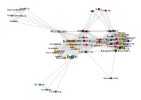

In [11]:
gplot(Graph(dist.>2),nodelabel=townlabel,nodelabelsize=log.(townpop),nodesize=log.(townpop),nodefillc=nodefillc)

## Build state-wide contact network

Using the inter-locale transport network (above) and a common contact pattern within communities, we now infer a model of interpersonal interaction at the level of the state. `buildstate()` uses the similarity score between communities defined by `similaritytown()` to build a contact model for every person in the state.

In [12]:
function buildstate(statedata,netbuilder)
    # buildstate(statedata, netbuilder)
    ##############################################################################
    #statedata is a csv table loaded from the structure /format above (AKA the Orlando Format)
    #netbuilder is the intra-locale network construction rule (a function)
    ##############################################################################
    #
    #extract the data from CSV table
    locale=statedata[1:2:end, 1]
    popl=parse.(Int, replace.(statedata[1:2:end,2], r","=> ""))
    distrc=statedata[1:2:3, 3]
    npl=length(popl)
    ###############
  #  nppl=1000 # assume 1 in 1000 people moving, on average
    ###############
    net=SimpleGraph() #empty graph
    transit=Array{Int64,2}(undef,npl,npl) #number of transits beween locale[i] and locale[j]
    for (i,town) in enumerate(locale)
        println("Adding ",town," (population: ",popl[i],")")
        #add the intralocale links
        netadd=netbuilder(popl[i]) #use the preassigned method to add the new component
        net=blockdiag(net,netadd)
        #compute the amount of transit
        for j in 1:(i-1) #number of transit between here and every other previous part
        transit[i,j] = Int(floor(similaritytown(statedata,i,j)))
            transit[j,i]=transit[i,j]
        end
        transit[i,i]=0
    end
    #add the inter-locale links too --- could do it in the same (previous) loops, but this is clearer (I think)
    rr=[0; cumsum(popl)]
    nedges_add = 0
    for i in 1:npl
        for j in (i+1):npl
            edg1=rand(collect(rr[i]+1:rr[i+1]),transit[i,j])
            edg2=rand(collect(rr[j]+1:rr[j+1]),transit[i,j])
            for k in 1:transit[i,j]
                add_edge!(net,edg1[k],edg2[k]) #this is grossly inefficient
                nedges_add += 1
            end
        end
    end
    #all done
    println(" $nedges_add edges added")
    return net, transit, locale, popl, distrc, nedges_add
end

buildstate (generic function with 5 methods)

## Build state level network

Note that the first argument is just the dataframe, stucture is inferred using buildstate and similaritytown described above. The level of sommunity interaction is the second argument, this is one of the graph generators defined earlier (in `ContactModels.jl`)

In [13]:
net, transit, locale, popl, distrc = buildstate(wapop[1:end-1,:], x -> covidsafe(nomassmix(x),0.5))
#net, transit, locale, popl, distrc = buildstate(wapop[1:end-1,:], x -> nomassmix(x))
#net, transit, locale, popl, distrc = buildstate(wapop[1:end-1,:], x -> fullmixing(x))

Adding Perth (population: 1874578)
Adding Bunbury (population: 71090)
Adding Geraldton (population: 31982)
Adding Kalgoorlie-Boulder (population: 29875)
Adding Albany (population: 29373)
Adding Busselton (population: 25329)
Adding Karratha (population: 15828)
Adding Broome (population: 13984)
Adding Port Hedland (population: 13828)
Adding Esperance (population: 10421)
Adding Yanchep (population: 8859)
Adding Collie (population: 7192)
Adding Northam (population: 6548)
Adding Margaret River (population: 6392)
Adding Dunsborough (population: 6039)
Adding Newman (population: 4567)
Adding Carnarvon (population: 4426)
Adding Kununurra (population: 4341)
Adding Narrogin (population: 4274)
Adding Manjimup (population: 4213)
Adding Pinjarra (population: 3896)
Adding Katanning (population: 3702)
Adding Derby (population: 3325)
Adding Tom Price (population: 2956)
Adding Port Denison-Dongara (population: 2782)
Adding Harvey (population: 2750)
Adding Merredin (population: 2636)
Adding Denmark (popu

({2325735, 3681015} undirected simple Int64 graph, [0 141 … 132 0; 141 0 … 22 0; … ; 132 22 … 0 0; 0 0 … 0 0], Union{Missing, String}["Perth", "Bunbury", "Geraldton", "Kalgoorlie-Boulder", "Albany", "Busselton", "Karratha", "Broome", "Port Hedland", "Esperance"  …  "Kalbarri", "Serpentine", "Binningup", "Kojonup", "Boddington-Ranford", "Fitzroy Crossing", "Augusta", "Dampier", "Mandurah", "Wyndham"], [1874578, 71090, 31982, 29875, 29373, 25329, 15828, 13984, 13828, 10421  …  1349, 1265, 1227, 1165, 1147, 1141, 1109, 1104, 80813, 780], Union{Missing, String}["Perth", "South West"], 34530)

## Visualise

Just to check what it all looks like - fun and pretty but not particularly informative and may just be really slow. Suggest you skip this bit.


In [14]:
function getbiggestbit(net)
    #dentify the vertices in the largest connected component of net
    cc=connected_components(net)
    bigi=0
    bign=0
    Threads.@threads for i in 1:length(cc)
        if length(cc[i])>bign 
            bign=length(cc[i])
            bigi=i
        end
    end
    return cc[bigi]
end

getbiggestbit (generic function with 1 method)

Size of net(2325735, 2325735)
Size of largest connected component(2214125, 2214125)


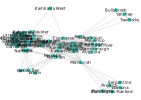

In [15]:
println("Size of net",size(net))
bnet=net[getbiggestbit(net)]
println("Size of largest connected component",size(bnet))
gplot(Graph(transit),nodelabel=locale) #this should work, but is a bit slow at the moment...

In [16]:
#bnet=net[getbiggestbit(net)]
#ndsz=[length(neighbors(bnet,vert)) for vert in vertices(bnet)]
#gplot(bnet, nodefillc=colorant"red",nodesize=ndsz,NODESIZE=0.05)

In [17]:
size(net)

(2325735, 2325735)

In [18]:
ourcolours=range(HSV(0,1,1), stop=HSV(-300,1,1), length=20)

In [19]:
#membri=Array{Int,1}(undef,62718)
#cpop=cumsum([1;popl])
#for i in 1:length(popl)
#    membri[cpop[i]:cpop[i+1]-1] .= i
#end
#nodefillc = ourcolours[membri]
#ndsz=[length(neighbors(net,vert)) for vert in vertices(net)];

In [20]:
#pretty, but slow
#gplot(net, nodefillc=nodefillc,nodesize=ndsz,NODESIZE=0.1)

## Simulate

Now comes the (final) fun part. Perform the full agent based simulation with the epidemic propagation parameters defined above and the contact network we've just generated for the state


In [21]:
#'reasonable' parameters ################################
epiparam=Dict()
epiparam["p0"]=0.2 #a guess - tuned to match observed data 
epiparam["p2"]=1/12 #revised infection rate with distancing measure
epiparam["q"]=1/7 #"up to" two weeks
epiparam["r0"]=1/14 #about two weeks for mild, 3-6 for severe
epiparam["r2"]=1/4 #revised removal rate (now due to testing and isolation)
#########################################################
epiparam["nseeds"]=5 #probably too many, consider dropping. 
epiparam["pop"]=size(net)[1]

2325735

In [22]:
ndays=90
nsims=200
St,Et,It,Rt = EpiSim.episim(net, epiparam, ndays, nsims)  #no change-point nsims simulations for ndays days

97.0%┣███████████████████████████████████████▊ ┫ 194/200 [02:28<00:05, 1.3 it/s]

(UInt64[0x0000000000237ce2 0x0000000000237ce2 … 0x0000000000237ce2 0x0000000000237ce2; 0x0000000000237ce0 0x0000000000237ce2 … 0x0000000000237ce2 0x0000000000237ce1; … ; 0x0000000000230c0c 0x0000000000235474 … 0x000000000022d5d8 0x000000000022eff2; 0x0000000000230077 0x00000000002350a4 … 0x000000000022c4cc 0x000000000022e215], UInt64[0x0000000000000003 0x0000000000000004 … 0x0000000000000005 0x0000000000000003; 0x0000000000000004 0x0000000000000004 … 0x0000000000000005 0x0000000000000004; … ; 0x0000000000002efc 0x0000000000000fea … 0x0000000000004581 0x0000000000003acf; 0x0000000000003406 0x0000000000001179 … 0x0000000000004cb9 0x0000000000003ff7], UInt64[0x0000000000000002 0x0000000000000001 … 0x0000000000000000 0x0000000000000002; 0x0000000000000003 0x0000000000000001 … 0x0000000000000000 0x0000000000000002; … ; 0x00000000000026dd 0x0000000000000e37 … 0x0000000000003996 0x000000000000302e; 0x0000000000002a6b 0x0000000000000f7d … 0x0000000000003f5c 0x0000000000003576], UInt64[0x000000

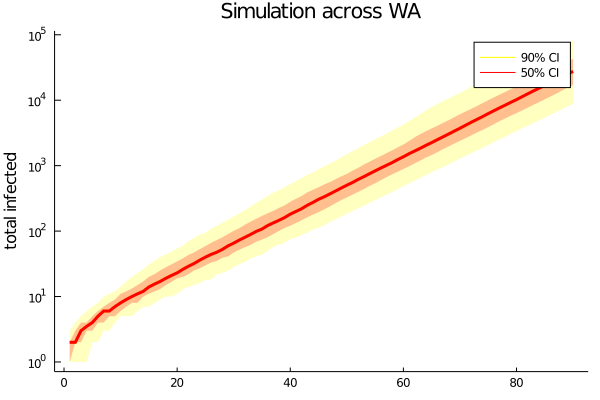

In [23]:
#log scale plot of model growth in infection 
plot(title="Simulation across WA", ylabel="total infected",yaxis=:log)
EpiSim.plotquantiles(It+Rt.+1,:yellow,"90% CI",0.45) #need to add one, otherwise log gets upset
EpiSim.plotquantiles(It+Rt.+1,:red,"50% CI",0.25)

In [24]:
#now, do the same things, but keep track of the count in each town
ndays=210
nsims=500
locpop=cumsum([1; popl],dims=1)
St,Et,It,Rt = EpiSim.episimcom(net, locpop, epiparam, ndays, nsims)  #no change-point nsims simulations for ndays days
#St[i,j,k] is the number of susceptibles in locale k on day i of simulation j
;


94.0%┣██████████████████████████████████████▌  ┫ 470/500 [12:33<00:48, 0.6 it/s]

## Probability of local transmission by region

This is probably the most sensible thing to look at from these simulations. Infection is intiiated in Perth, given some level of containment, social isolation and contact tracing as defined by the network generation model (see `contact_models.ipynb` for details and examples, code is duplicated and reused here from `ContactModels.jl`) and some state-level interaction pattern (determined by `similaritytown()`, above) what is the probability of local transmission reaching particular communities?

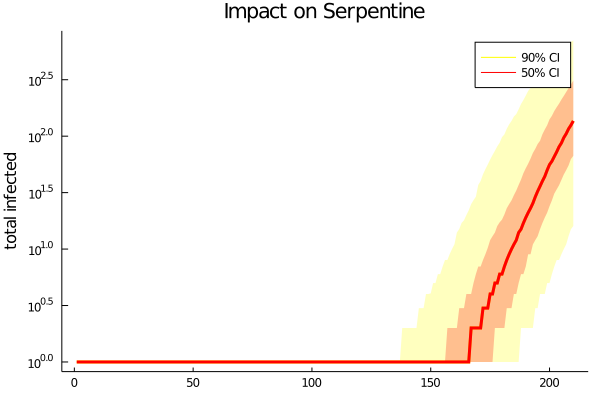

In [25]:
#log scale plot of model growth in infection 
lcl=50
plot(title="Impact on "*locale[lcl], ylabel="total infected",yaxis=:log)
EpiSim.plotquantiles(It[:,:,lcl]+Rt[:,:,lcl].+1,:yellow,"90% CI",0.45) #need to add one, otherwise log gets upset
EpiSim.plotquantiles(It[:,:,lcl]+Rt[:,:,lcl].+1,:red,"50% CI",0.25)

In [26]:
nday=[120 90 60 30]
impactloc=Array{Float64,2}(undef, length(locale), length(nday))
for n in 1:1:length(nday)
    for k in 1:length(locale)
        impactloc[k,n]=100*sum((It[nday[n],:,k]+Rt[nday[n],:,k]).>0)/nsims
       # println(locale[k]," affected ",impactloc[k],"%")
    end
end

In [27]:
plotly()

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/michael/.julia/packages/Plots/6EMd6/src/backends.jl:372


Plots.PlotlyBackend()

In [28]:
bar(locale,impactloc, rotation=90, ylabel="probability of local spread", xticks=(0.5:1:length(locale),locale),linetype=:bar,label=nday,size=(3500,600),title="Estimated vulnerability" )

<!DOCTYPE html>
 
 
 Plots.jl

## Michael Small

Now in working order. The assumption underlying the modelling need to be better explored. But the model itself, works.

## 23/6/21